## Imports

In [3]:
import functools
import os

from clu import metric_writers
import numpy as np
import jax
import jax.numpy as jnp
from jax.experimental import sparse
import matplotlib.pyplot as plt
import optax
import orbax.checkpoint as ocp

import h5py
import natsort
import tensorflow as tf
from scipy.ndimage import geometric_transform
from scipy.ndimage import gaussian_filter

2024-03-08 00:22:07.243087: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
%cd ..

/grad/bzhang388/pisp/DeterministicModels


/grad/bzhang388/anaconda3/envs/jaxflax/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
from src import models
from src import trainers
from WideBNetModel import morton
from WideBNetModel import WideBNet 

from swirl_dynamics import templates
from swirl_dynamics.lib import metrics
from pysteps.utils.spectral import rapsd

Pysteps configuration file found at: /grad/bzhang388/anaconda3/envs/jaxflax/lib/python3.10/site-packages/pysteps/pystepsrc



In [6]:
jax.devices()

[cuda(id=0), cuda(id=1)]

### Dataset

In [7]:
# Parameters for the computational task.

L = 4 # number of levels (even number)
s = 5 # leaf size
r = 3 # rank

# Discretization of Omega (n_eta * n_eta).
neta = (2**L)*s

# Number of sources/detectors (n_sc).
# Discretization of the domain of alpha in polar coordinates (n_theta * n_rho).
# For simplicity, these values are set equal (n_sc = n_theta = n_rho), facilitating computation.
nx = (2**L)*s

idx_flatten_to_morton = morton.flatten_to_morton_indices(L, s)
idx_morton_to_flatten = morton.morton_to_flatten_indices(L, s)

# Standard deviation for the Gaussian blur.
blur_sigma = 0.5

# Batch size.
BATCH_SIZE = 16

# Number of training datapoints.
NTRAIN = 20000

# Number of testing datapoints.
NTEST = 512

# Total number
NTOTAL = NTRAIN + NTEST

In [23]:
tf.config.set_visible_devices([], device_type='GPU')

name = '../data/10squares'

# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTRAIN, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re = np.stack([blur_fn(eta_re[i, :, :].T) for i in range(NTRAIN)]).astype('float32')

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTRAIN, :]
    tmp2 = f[keys[4]][:NTRAIN, :]
    tmp3 = f[keys[5]][:NTRAIN, :]
    scatter_re = np.stack((tmp3, tmp2, tmp1), axis=-1)
    scatter_re = scatter_re[:, idx_flatten_to_morton, :]
    
    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTRAIN, :]
    tmp2 = f[keys[1]][:NTRAIN, :]
    tmp3 = f[keys[2]][:NTRAIN, :]
    scatter_im = np.stack((tmp3, tmp2, tmp1), axis=-1)
    scatter_im = scatter_im[:, idx_flatten_to_morton, :]
    
    # Combine real and imaginary parts
    scatter = np.stack((scatter_re, scatter_im), axis=1).astype('float32')
    
# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

In [24]:
batch_size = 16
dict_data = {"eta": eta_re}
dict_data["scatter"] = scatter
dataset = tf.data.Dataset.from_tensor_slices(dict_data)
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=500)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.AUTOTUNE)
dataset = eval_dataloader = dataset.as_numpy_iterator()

### Architecture

In [25]:
core_module = WideBNet.WideBNetModel(
     L = L, s = s, r = r, NUM_RESNET = 3, idx_morton_to_flatten = idx_morton_to_flatten
)

In [26]:
Model = models.DeterministicModel(
    input_shape = scatter[0].shape,
    core_module = core_module
)

In [27]:
rng = jax.random.PRNGKey(888)
params = Model.initialize(rng)
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
print('Number of trainable parameters:', param_count)

Number of trainable parameters: 2105068


### Training

In [36]:
num_train_steps = 100000  #@param
workdir = os.path.abspath('') + "/tmp/WideBNet10Squares"  #@param
initial_lr = 0.0  #@param
peak_lr = 5e-3 #@param
warmup_steps = 500  #@param
end_lr = 1e-5  #@param
ckpt_interval = 2000  #@param
max_ckpt_to_keep = 5  #@param

In [37]:
trainer = trainers.DeterministicTrainer(
    model=Model, 
    rng=jax.random.PRNGKey(42), 
    optimizer=optax.adam(
        learning_rate=optax.warmup_cosine_decay_schedule(
            init_value=initial_lr,
            peak_value=peak_lr,
            warmup_steps=warmup_steps,
            decay_steps=num_train_steps,
            end_value=end_lr,
        ),
    ),
)
     

In [38]:
templates.run_train(
    train_dataloader=dataset,
    trainer=trainer,
    workdir=workdir,
    total_train_steps=num_train_steps,
    metric_writer=metric_writers.create_default_writer(
        workdir, asynchronous=False
    ),
    metric_aggregation_steps = 100,
    eval_dataloader = eval_dataloader,
    eval_every_steps = 1000,
    num_batches_per_eval = 2,
    callbacks=(
        templates.TqdmProgressBar(
            total_train_steps=num_train_steps,
            train_monitors=("train_loss",),
            eval_monitors=("eval_rrmse_mean",),
        ),
        templates.TrainStateCheckpoint(
            base_dir=workdir,
            options=ocp.CheckpointManagerOptions(
                save_interval_steps=ckpt_interval, max_to_keep=max_ckpt_to_keep
            ),
        ),
    ),
)

  0%|          | 0/100000 [00:00<?, ?step/s]

### Inference

In [39]:
trained_state = trainers.TrainState.restore_from_orbax_ckpt(
    f"{workdir}/checkpoints", step=None
)

In [40]:
inference_fn = trainers.DeterministicTrainer.build_inference_fn(
    trained_state, core_module
)

In [41]:
# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][NTRAIN:NTOTAL, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_test = np.stack([blur_fn(eta_re[i, :, :].T) for i in range(NTEST)]).astype('float32')

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][NTRAIN:NTOTAL, :]
    tmp2 = f[keys[4]][NTRAIN:NTOTAL, :]
    tmp3 = f[keys[5]][NTRAIN:NTOTAL, :]
    scatter_re = np.stack((tmp3, tmp2, tmp1), axis=-1)
    scatter_re = scatter_re[:, idx_flatten_to_morton, :]
    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][NTRAIN:NTOTAL, :]
    tmp2 = f[keys[1]][NTRAIN:NTOTAL, :]
    tmp3 = f[keys[2]][NTRAIN:NTOTAL, :]
    scatter_im = np.stack((tmp3, tmp2, tmp1), axis=-1)
    scatter_im = scatter_im[:, idx_flatten_to_morton, :]
    # Combine real and imaginary parts
    scatter_test = np.stack((scatter_re, scatter_im), axis=1).astype('float32')
    
# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3


In [42]:
test_dataset = tf.data.Dataset.from_tensor_slices((scatter_test, eta_test))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = eval_dataloader = test_dataset.as_numpy_iterator()

In [43]:
validation_errors_rrmse = [] 
validation_errors_rapsd = [] 

rrmse = functools.partial(
        metrics.mean_squared_error,
        sum_axes=(-1, -2),
        relative=True,
        squared=False,
    )

for batch in test_dataset:
    pred = inference_fn(batch[0])
    true = batch[1]
    validation_errors_rrmse.append(rrmse(pred=pred, true=true))
    for i in range(batch_size):
        validation_errors_rapsd.append(np.abs(np.log(rapsd(pred[i],fft_method=np.fft)/rapsd(true[i],fft_method=np.fft))))

print('relative root-mean-square error = %.3f' % (np.mean(validation_errors_rrmse)*100), '%') 
print('radially averaged power spectrum = %.3f' % np.mean(validation_errors_rapsd)) 

relative root-mean-square error = 16.324 %
radially averaged power spectrum = 0.306


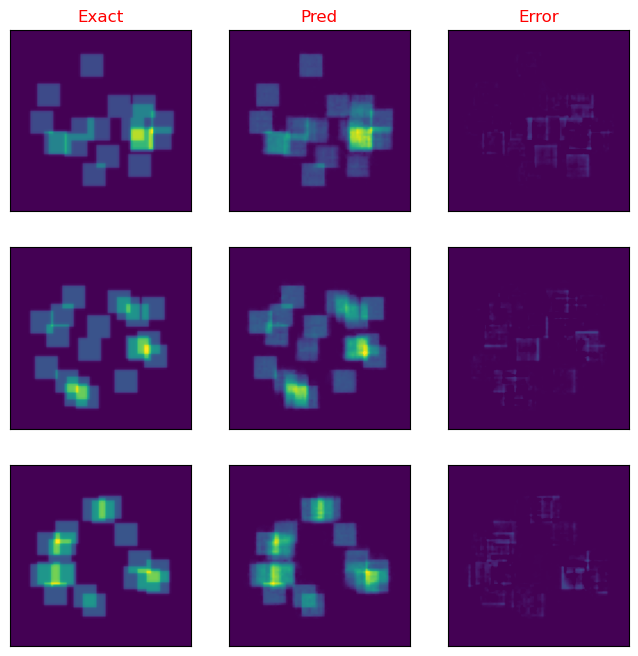

In [44]:
fig = plt.figure(figsize=(8,8))
NPLOT = 3
for kk in range(NPLOT):
    plt.subplot(NPLOT, 3, kk*NPLOT + 1)
    plt.imshow(batch[1][kk,:,:])
    plt.xticks([]); plt.yticks([]); clim = plt.gci().get_clim();
    if kk == 0:
        plt.title('Exact', color='red')

    plt.subplot(NPLOT, 3, kk*NPLOT + 2)
    plt.imshow(pred[kk,:,:])
    plt.xticks([]); plt.yticks([]); plt.gci().set_clim(clim);
    if kk == 0:
        plt.title('Pred', color='red')

    plt.subplot(NPLOT, 3, kk*NPLOT + 3)
    plt.imshow(batch[1][kk,:,:]-pred[kk,:,:])
    plt.xticks([]); plt.yticks([]); plt.gci().set_clim(clim);
    if kk == 0:
        plt.title('Error', color='red')                
plt.show()
fig.savefig('widebnet10squares.png')